## Interpolation of JRA Winds

In [35]:
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from scipy.io import loadmat
import numpy as np
import re
from xml.etree import ElementTree as ET
from matplotlib.path import Path
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import math
import xoak
from tqdm import tqdm

In [2]:
## Croco elements
ds = xr.open_dataset('../../NHCS/hincast_1980-2015/croco_avg_Y1980M01.nc', 
                     chunks = {'time':1})
ds

<xarray.Dataset> Size: 891MB
Dimensions:     (xi_rho: 602, xi_u: 601, eta_rho: 542, eta_v: 541, s_rho: 32,
                 s_w: 33, time: 1, auxil: 4)
Coordinates: (12/13)
  * xi_rho      (xi_rho) float64 5kB 1.0 2.0 3.0 4.0 ... 599.0 600.0 601.0 602.0
  * xi_u        (xi_u) float64 5kB 1.5 2.5 3.5 4.5 ... 598.5 599.5 600.5 601.5
  * eta_rho     (eta_rho) float64 4kB 1.0 2.0 3.0 4.0 ... 540.0 541.0 542.0
  * eta_v       (eta_v) float64 4kB 1.5 2.5 3.5 4.5 ... 538.5 539.5 540.5 541.5
  * s_rho       (s_rho) float64 256B -0.9844 -0.9531 ... -0.04688 -0.01562
  * s_w         (s_w) float64 264B -1.0 -0.9688 -0.9375 ... -0.0625 -0.03125 0.0
    ...          ...
    lat_rho     (eta_rho, xi_rho) float64 3MB dask.array<chunksize=(542, 602), meta=np.ndarray>
    lon_u       (eta_rho, xi_u) float64 3MB dask.array<chunksize=(542, 601), meta=np.ndarray>
    lat_u       (eta_rho, xi_u) float64 3MB dask.array<chunksize=(542, 601), meta=np.ndarray>
    lon_v       (eta_v, xi_rho) float64 3MB dask.array<chunksize=(541, 602), meta=np.ndarray>
    lat_v       (eta_v, xi_rho) float64 3MB dask.array<chunksize=(541, 602), meta=np.ndarray>
  * time        (time) float32 4B 1.339e+06
Dimensions without coordinates: auxil
Data variables: (12/54)
    spherical   |S1 1B ...
    xl          float64 8B ...
    el          float64 8B ...
    Vtransform  float64 8B ...
    sc_r        (s_rho) float64 256B dask.array<chunksize=(32,), meta=np.ndarray>
    sc_w        (s_w) float64 264B dask.array<chunksize=(33,), meta=np.ndarray>
    ...          ...
    swflux      (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    radsw       (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    shflx_rlw   (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    shflx_lat   (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    shflx_sen   (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
    hel         (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 542, 602), meta=np.ndarray>
Attributes: (12/57)
    type:           ROMS restart file
    title:          Peru UW Interannual Run
    date:           
    rst_file:       croco_rst.nc
    his_file:       croco_his.nc
    avg_file:       croco_avg.nc
    ...             ...
    gamma2_expl:    Slipperiness parameter
    x_sponge:       0.0
    v_sponge:       0.0
    sponge_expl:    Sponge parameters : extent (m) & viscosity (m2.s-1)
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL PERU_UW MPI OBC_WEST OBC_NORTH OBC_SOUTH BIOLOGY...

In [9]:
mask=ds.mask_rho.compute()
mask = np.where(mask == 0, np.nan, mask)
mask

lon=ds.lon_rho.compute()
lat=ds.lat_rho.compute()


lons=(math.floor(lon.min().item())+360,math.floor(lon.max().values.item()+360))
lats=(math.floor(lat.max().item()),math.floor(lat.min().item()))

In [68]:
JRApath='/gxfs_work/geomar/smomw662/NHCS/Winds_input/JRA/'
ds_JRA = xr.load_dataset(JRApath+"anl_surf125.033_ugrd.1958010100_1958123118", engine="cfgrib").u10.sel(latitude=slice(*lats), longitude=slice(*lons))
ds_JRA['longitude']=ds_JRA.longitude -360
ds_JRA.time.shape

(1460,)

In [79]:
int(ds_JRA.time.shape[0])

1460

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1460/1460 [01:41<00:00, 14.36it/s]


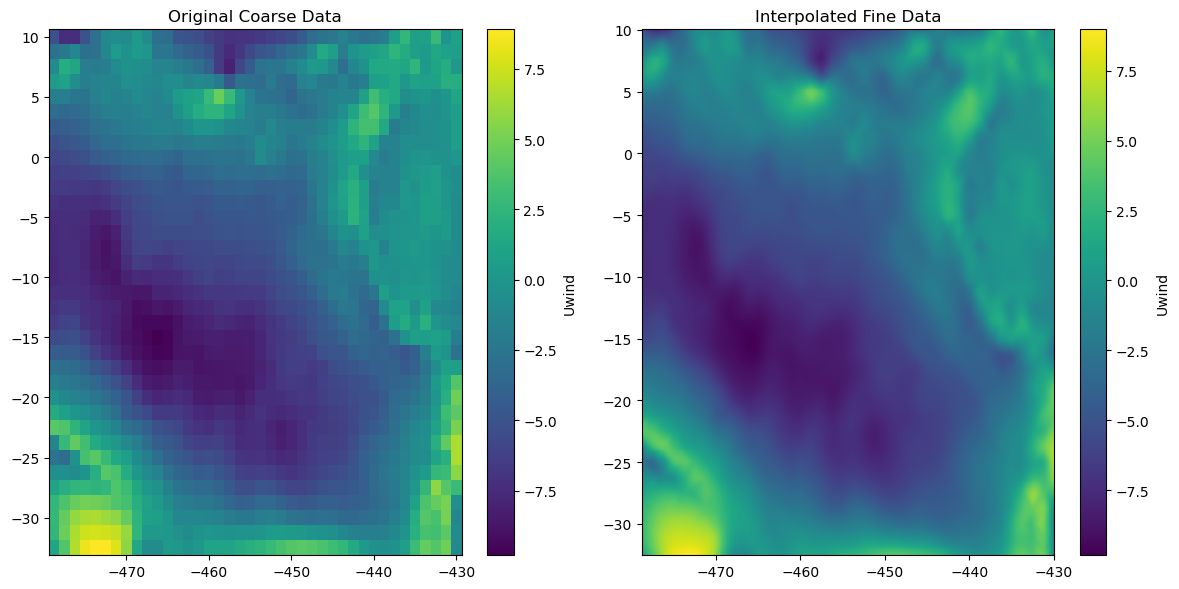

In [36]:
# Assuming ds_JRA is your original dataset with dimensions (time, lat, lon)
# Example: ds_JRA = xr.open_dataset('your_file.nc')

# Step 1: Create the target fine grid (lon=602, lat=542)
lon_fine = np.linspace(ds_JRA.longitude.values.min(), ds_JRA.longitude.values.max(), 602)
lat_fine = np.linspace(ds_JRA.latitude.values.min(), ds_JRA.latitude.values.max(), 542)
lon_grid_fine, lat_grid_fine = np.meshgrid(lon_fine, lat_fine)

# Step 2: Extract the original coarse grid (lon=40, lat=35)
lon_coarse = ds_JRA.longitude.values.flatten()
lat_coarse = ds_JRA.latitude.values.flatten()
lon_grid_coarse, lat_grid_coarse = np.meshgrid(lon_coarse, lat_coarse)

# Step 3: Initialize an empty array to store the interpolated data
interpolated_data = np.zeros((1460, 542, 602))

# Step 4: Loop over each time step
# for year in tqdm(range(1960, 2057+1,1)):
for t in tqdm(range(1460)):
    # Extract the data for the current time step
    data_coarse = ds_JRA.isel(time=t).values  # Assuming the variable is named 'Uwind'
    
    # Flatten the coarse grid coordinates and data for interpolation
    coords_coarse = np.column_stack((lon_grid_coarse.flatten(), lat_grid_coarse.flatten()))
    data_coarse_flat = data_coarse.flatten()
    
    # Flatten the target fine grid coordinates
    coords_fine = np.column_stack((lon_grid_fine.flatten(), lat_grid_fine.flatten()))
    
    # Perform interpolation (linear or cubic)
    data_fine_flat = griddata(
        coords_coarse,  # Original coordinates (shape: (40*35, 2))
        data_coarse_flat,  # Original data (shape: (40*35,))
        coords_fine,  # Target coordinates (shape: (602*542, 2))
        method='cubic'  # or 'linear' for faster results
    )
    
    # Reshape the interpolated data to the fine grid shape
    interpolated_data[t, :, :] = data_fine_flat.reshape((542, 602))

# Step 5: Create a new xarray.DataArray for the interpolated data
interpolated_da = xr.DataArray(
    interpolated_data,
    dims=('time', 'lat', 'lon'),
    coords={
        'time': ds_JRA.time.values,
        'lat': lat_fine,
        'lon': lon_fine
    }
)



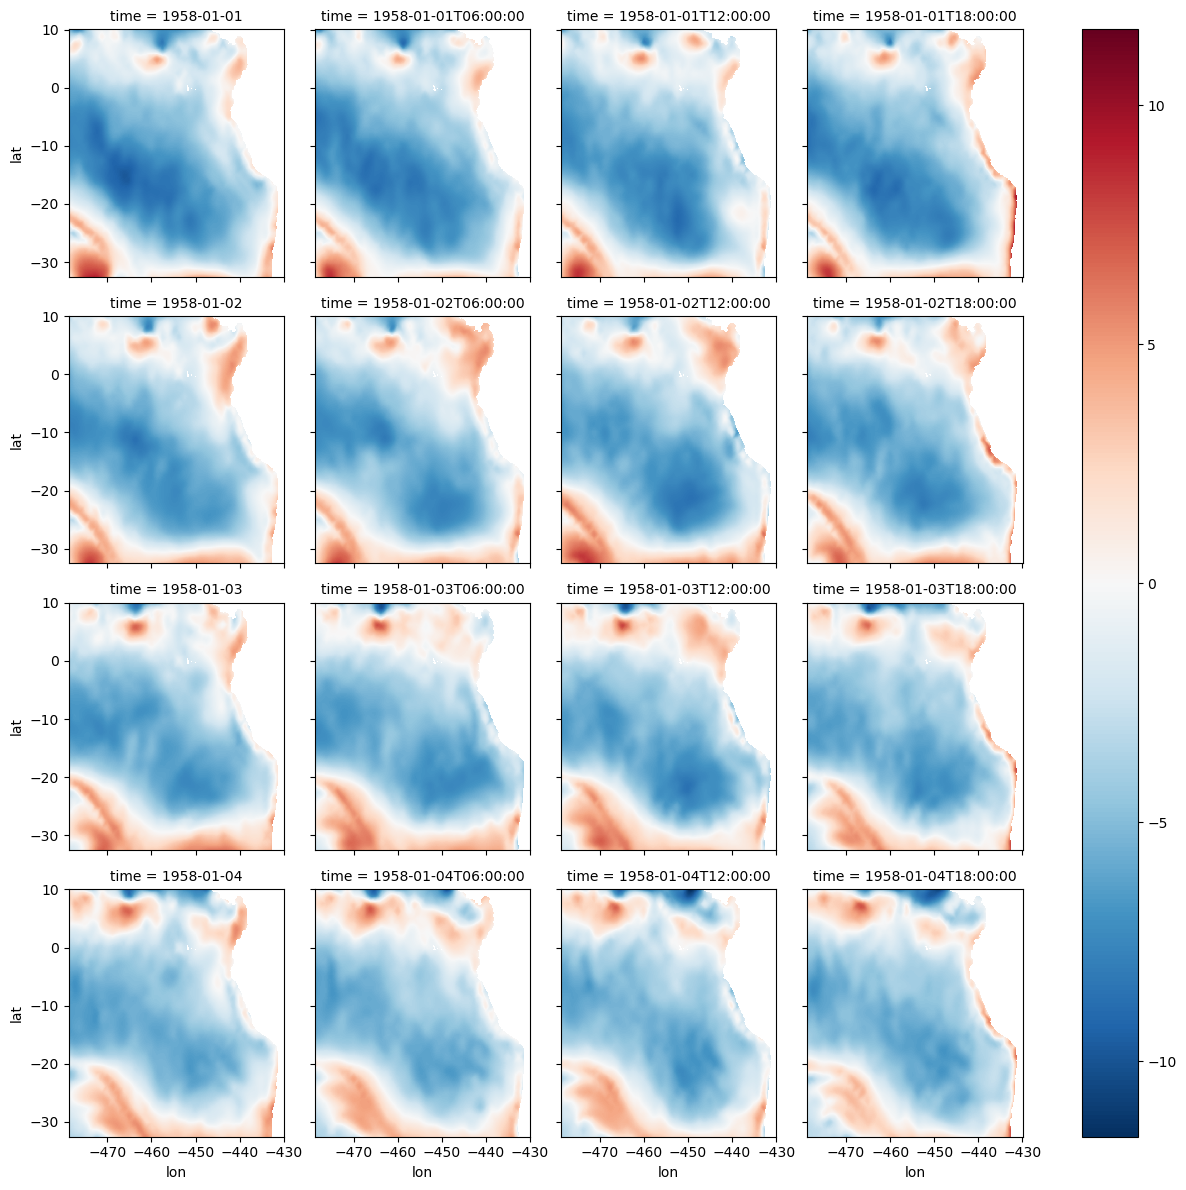

In [40]:
u10=interpolated_da *mask
u10.isel(time=slice(None,16)).plot(x='lon', 
                                        y='lat', col='time',col_wrap=4)

In [83]:
ds_new = xr.open_dataset('/gxfs_work/geomar/smomw662/NHCS/Winds_input/JRA_interp/u10.1980.nc')
ds_new.compute()
ds_new

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 1464, lat: 542, lon: 602)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1980-01-01 ... 1980-12-31T18:00:00
  * lat      (lat) float64 4kB -32.85 -32.78 -32.7 -32.62 ... 9.671 9.749 9.828
  * lon      (lon) float64 5kB -118.7 -118.6 -118.5 ... -69.35 -69.27 -69.19
Data variables:
    u10      (time, lat, lon) float64 4GB ...

In [84]:
ds_new.u10.values

array([[[-6.24276733, -6.24536669, -6.24722961, ...,         nan,
                 nan,         nan],
        [-6.38814473, -6.38984585, -6.3871638 , ...,         nan,
                 nan,         nan],
        [-6.52577181, -6.5264504 , -6.51950211, ...,         nan,
                 nan,         nan],
        ...,
        [-7.01029524, -7.0195178 , -7.0281448 , ...,         nan,
                 nan,         nan],
        [-6.98781292, -6.99552198, -7.00287377, ...,         nan,
                 nan,         nan],
        [-6.96444702, -6.97050726, -6.97650392, ...,         nan,
                 nan,         nan]],

       [[-4.48162842, -4.50457915, -4.52731362, ...,         nan,
                 nan,         nan],
        [-4.40437839, -4.43014813, -4.45620805, ...,         nan,
                 nan,         nan],
        [-4.32799165, -4.35634563, -4.38549789, ...,         nan,
                 nan,         nan],
        ...,
        [-6.48523687, -6.46059024, -6.43631592, ...,  